In [1]:
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Custom functions
from useful_lca_functions import get_inventory_dataset, init_simple_lca, multi_lcia
from visualisation_functions import heatmap_lca, heatmap_db_comparison

# LCA

## Import LCI and LCIA methods

In [12]:
bd.projects.set_current("regioinvent_2025")
bd.databases

Databases dictionary with 9 object(s):
	LIB raw materials
	Regioinvent
	biosphere3
	biosphere3_spatialized_flows
	cobalt
	ecoinvent-3.10-cutoff
	ecoinvent-3.10-cutoff regionalized
	graphite
	lithium

In [13]:
EI_DB = 'ecoinvent-3.10-cutoff'
RI_DB = 'Regioinvent'

In [19]:
# From Ecoinvent
# (mineral name: activity name, reference product, location)
INVENTORIES_EI = {
    "Aluminium": ("market for aluminium, primary, ingot", "aluminium, primary, ingot", "IAI Area, North America"),
    "Antimony": ("market for antimony", "antimony", "GLO"),
    "Cadmium": ("market for cadmium", "cadmium", "GLO"),
    "Cobalt": ("market for cobalt oxide", "cobalt oxide", "GLO"),
    "Copper": ("market for copper, cathode", "copper, cathode", "GLO"),
    "Fluorspar": ("market for fluorspar, 97% purity", "fluorspar, 97% purity", "GLO"),
    "Gold": ("market for gold", "gold", "GLO"),
    "Graphite": ("market for graphite", "graphite", "GLO"),
    "Indium": ("market for indium", "indium", "GLO"),
    "Iron (Fe)": ("market for iron ore, crude ore, 46% Fe", "iron ore, crude ore, 46% Fe", "GLO"),
    "Lead": ("market for lead", "lead", "GLO"),
    "Molybdenum": ("market for molybdenum", "molybdenum", "GLO"),
    "Nickel": ("market for nickel, class 1", "nickel, class 1", "GLO"),
    "Niobium (Nb2O5)": ("market for ferroniobium, 66% Nb", "ferroniobium, 66% Nb", "GLO"),
    "Palladium": ("market for palladium", "palladium", "GLO"),
    "Platinum": ("market for platinum", "platinum", "GLO"),
    "Potash (K2O)": ("market for potash salt", "potash salt", "RoW"),
    "Rhodium": ("market for rhodium", "rhodium", "GLO"),
    "Selenium": ("market for selenium", "selenium", "GLO"),
    "Silver": ("market for silver", "silver", "GLO"),
    "Tellurium": ("market for tellurium, semiconductor-grade", "tellurium, semiconductor-grade", "GLO"),
    "Titanium (TiO2)": ("market for titanium dioxide", "titanium dioxide", "RoW"),
    "Uranium (U3O8)": ("market for uranium hexafluoride", "uranium hexafluoride", "RoW"),
    "Zinc": ("market for zinc", "zinc", "GLO") 
}

In [15]:
# From Regioinvent
# (mineral name: activity name, reference product, location)
INVENTORIES_RI = {
    "Aluminium": ("consumption market for aluminium, primary, ingot", "aluminium, primary, ingot", "CA"),
    "Antimony": ("consumption market for antimony", "antimony", "CA"),
    "Cadmium": ("consumption market for cadmium", "cadmium", "CA"),
    "Cobalt": ("consumption market for cobalt oxide", "cobalt oxide", "CA"),
    "Copper": ("consumption market for copper, cathode", "copper, cathode", "CA"),
    "Fluorspar": ("consumption market for fluorspar, 97% purity", "fluorspar, 97% purity", "CA"),
    "Gold": ("consumption market for gold", "gold", "CA"),
    "Graphite": ("consumption market for graphite", "graphite", "CA"),
    "Indium": ("consumption market for indium", "indium", "CA"),
    "Iron (Fe)": ("consumption market for iron ore, crude ore, 46% Fe", "iron ore, crude ore, 46% Fe", "CA"),
    "Lead": ("consumption market for lead", "lead", "CA"),
    "Molybdenum": ("consumption market for molybdenum", "molybdenum", "CA"),
    "Nickel": ("consumption market for nickel, class 1", "nickel, class 1", "CA"),
    "Niobium (Nb2O5)": ("consumption market for ferroniobium, 66% Nb", "ferroniobium, 66% Nb", "CA"),
    "Palladium": ("consumption market for palladium", "palladium", "CA"),
    "Platinum": ("consumption market for platinum", "platinum", "CA"),
    "Potash (K2O)": ("consumption market for potash salt", "potash salt", "CA"),
    "Rhodium": ("consumption market for rhodium", "rhodium", "CA"),
    "Selenium": ("consumption market for selenium", "selenium", "CA"),
    "Silver": ("consumption market for silver", "silver", "CA"),
    "Tellurium": ("consumption market for tellurium, semiconductor-grade", "tellurium, semiconductor-grade", "CA"),
    "Titanium (TiO2)": ("consumption market for titanium dioxide", "titanium dioxide", "CA"),
    "Uranium (U3O8)": ("consumption market for uranium hexafluoride", "uranium hexafluoride", "CA"),
    "Zinc": ("consumption market for zinc", "zinc", "CA") 
}

In [20]:
INVENTORIES_EI_ds = get_inventory_dataset(INVENTORIES_EI, database_names=[EI_DB])

In [17]:
INVENTORIES_RI_ds = get_inventory_dataset(INVENTORIES_RI, database_names=[RI_DB])

In [21]:
# We can also import some from IW+2.1
expert_ei310 = 'data/IW+2.1/impact_world_plus_21_brightway2_expert_version_ei310.5535d12bedce3770ffef004e84229fd1.bw2package'
bw.BW2Package.import_file(expert_ei310)

[Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Ecosystem quality: Climate change, ecosystem quality, long term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Ecosystem quality: Climate change, ecosystem quality, short term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Human health: Climate change, human health, long term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Human health: Climate change, human health, short term,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Midpoint: Climate change, long term,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Midpoint: Climate change, short term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Ecosystem quality: Fisheries impact,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Midpoint: Fossil and nuclear energy use,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Mid

In [22]:
IMPACT_METHODS = {
#'GWP100': ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'),
'Total HH': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10','Human health', 'Total human health'), 
'Total EQ': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10','Ecosystem quality', 'Total ecosystem quality'), 
}

## Perform specific LCA 

## With EI_DB

In [23]:
# Initialize LCA object
lca_ei = init_simple_lca(INVENTORIES_EI_ds["Aluminium"])

In [24]:
specific_lca_ei = {}
for rm in INVENTORIES_EI_ds:
    impacts = multi_lcia(lca_ei, INVENTORIES_EI_ds[rm], IMPACT_METHODS)
    specific_lca_ei[rm] = impacts

specific_lca_ei = pd.DataFrame(specific_lca_ei).T
specific_lca_ei = specific_lca_ei.reset_index().rename(columns={
    'index': 'Commodity',
})

In [25]:
specific_lca_ei

,Commodity,Total HH (DALY),Total EQ (PDF.m2.yr)
0,Aluminium,1.024659e-04,10.960175
1,Antimony,3.011373e-04,130.129644
2,Cadmium,6.016583e-05,5.021571
3,Cobalt,6.373749e-04,43.051577
4,Copper,2.354260e-04,37.624968
5,Fluorspar,2.001884e-06,0.239333
6,Gold,5.034590e-01,92956.653095
7,Graphite,5.974026e-07,0.080919
8,Indium,1.788017e-03,151.365088
9,Iron (Fe),1.166530e-07,0.053218


## With Regioinvent

In [26]:
# Initialize LCA object
lca_ri = init_simple_lca(INVENTORIES_RI_ds["Aluminium"])

In [27]:
specific_lca_ri = {}
for rm in INVENTORIES_RI_ds:
    impacts = multi_lcia(lca_ri, INVENTORIES_RI_ds[rm], IMPACT_METHODS)
    specific_lca_ri[rm] = impacts

specific_lca_ri = pd.DataFrame(specific_lca_ri).T
specific_lca_ri = specific_lca_ri.reset_index().rename(columns={
    'index': 'Commodity',
})

In [28]:
specific_lca_ri

,Commodity,Total HH (DALY),Total EQ (PDF.m2.yr)
0,Aluminium,4.757306e-05,5.280072
1,Antimony,1.789925e-04,117.978604
2,Cadmium,4.585213e-05,3.794301
3,Cobalt,2.554897e-04,31.457421
4,Copper,1.820514e-04,27.227589
5,Fluorspar,1.081942e-06,0.129954
6,Gold,2.314741e-01,58963.009689
7,Graphite,4.595039e-07,0.061759
8,Indium,1.522150e-03,118.056347
9,Iron (Fe),5.689976e-08,0.048911


## Compare and plot the differences

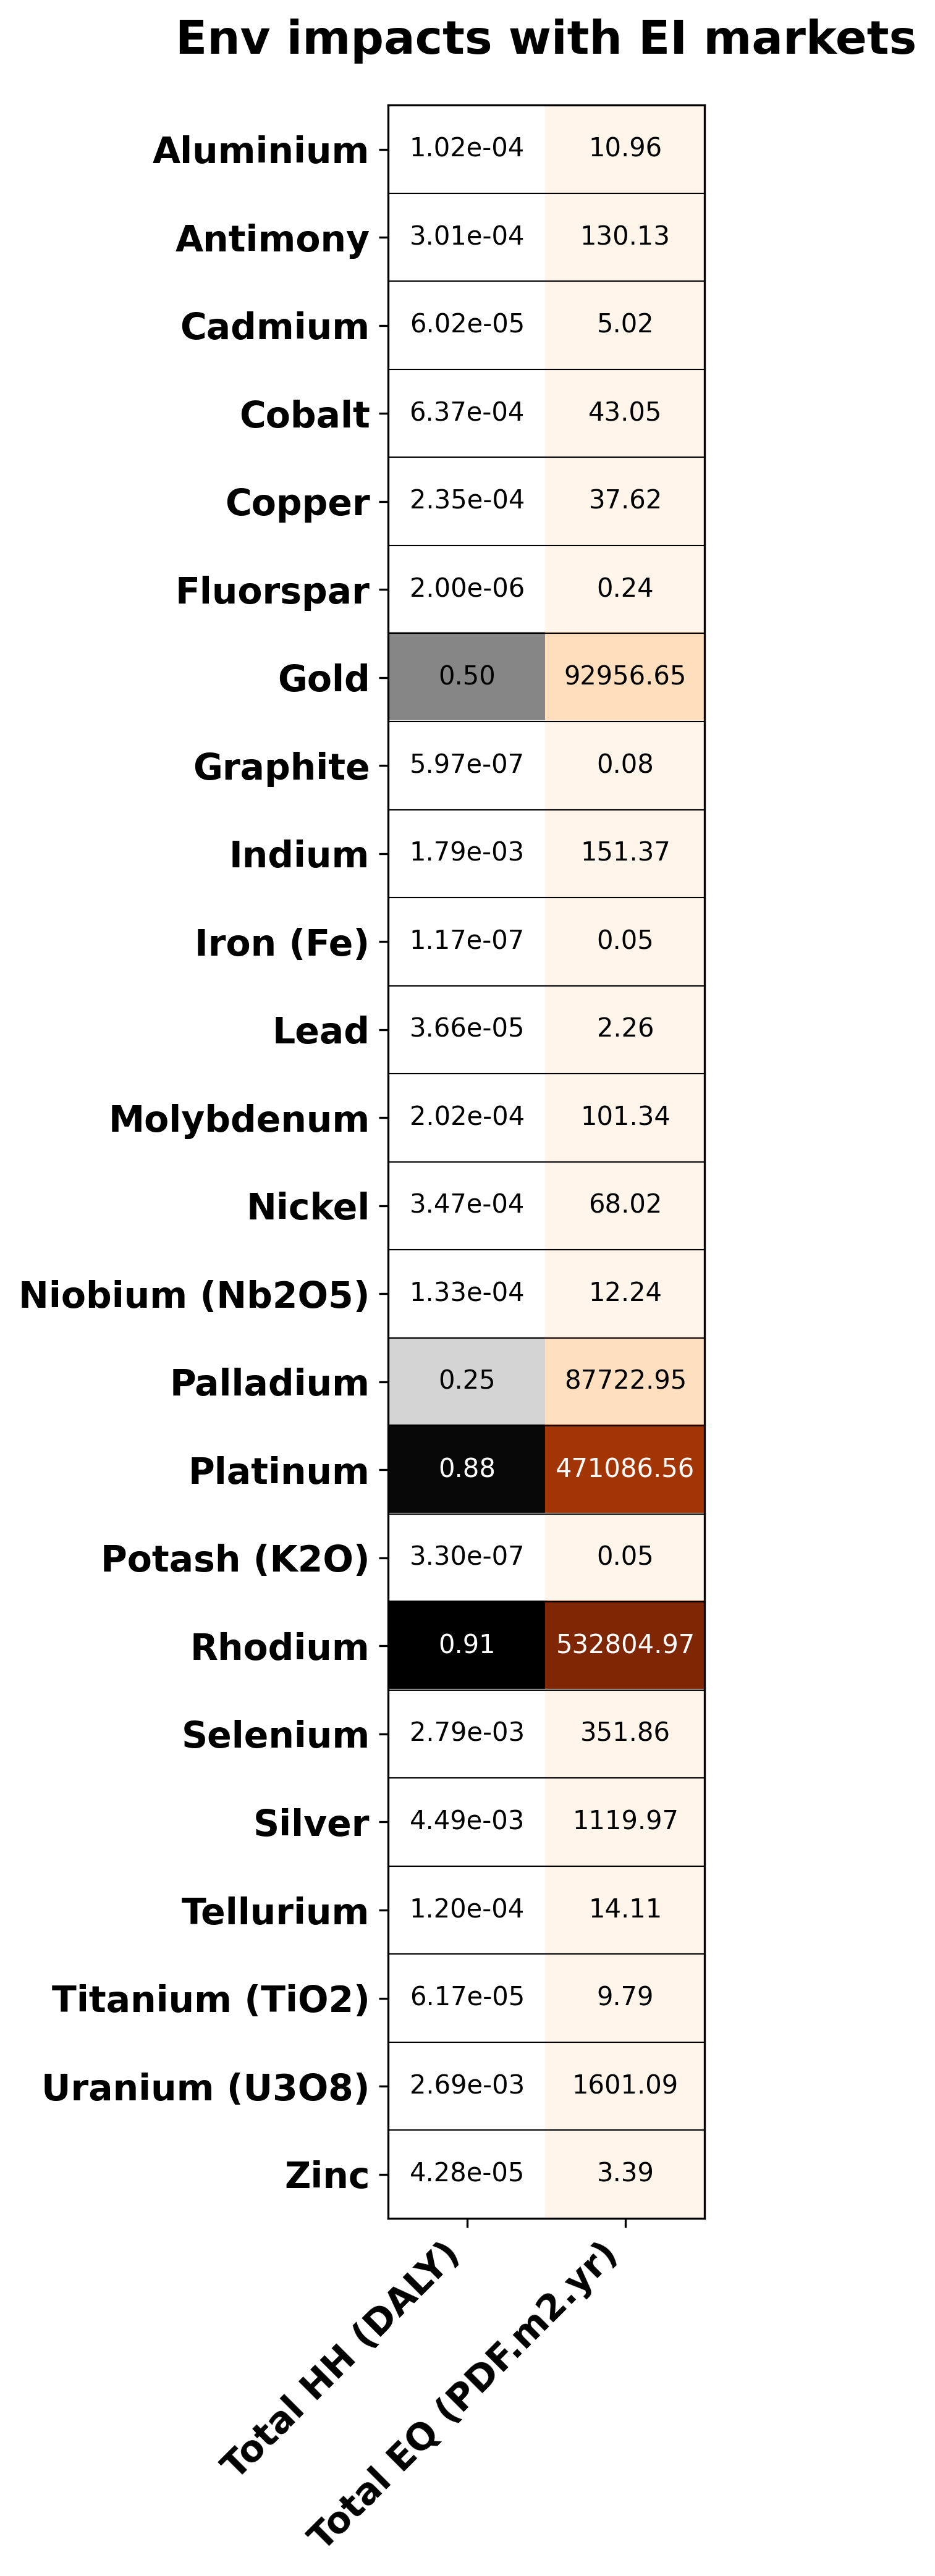

In [29]:
heatmap_lca(specific_lca_ei, 
            title='Env impacts with EI markets', 
            save_path='results/production_impacts_2023/env_impacts_market_ei.png')


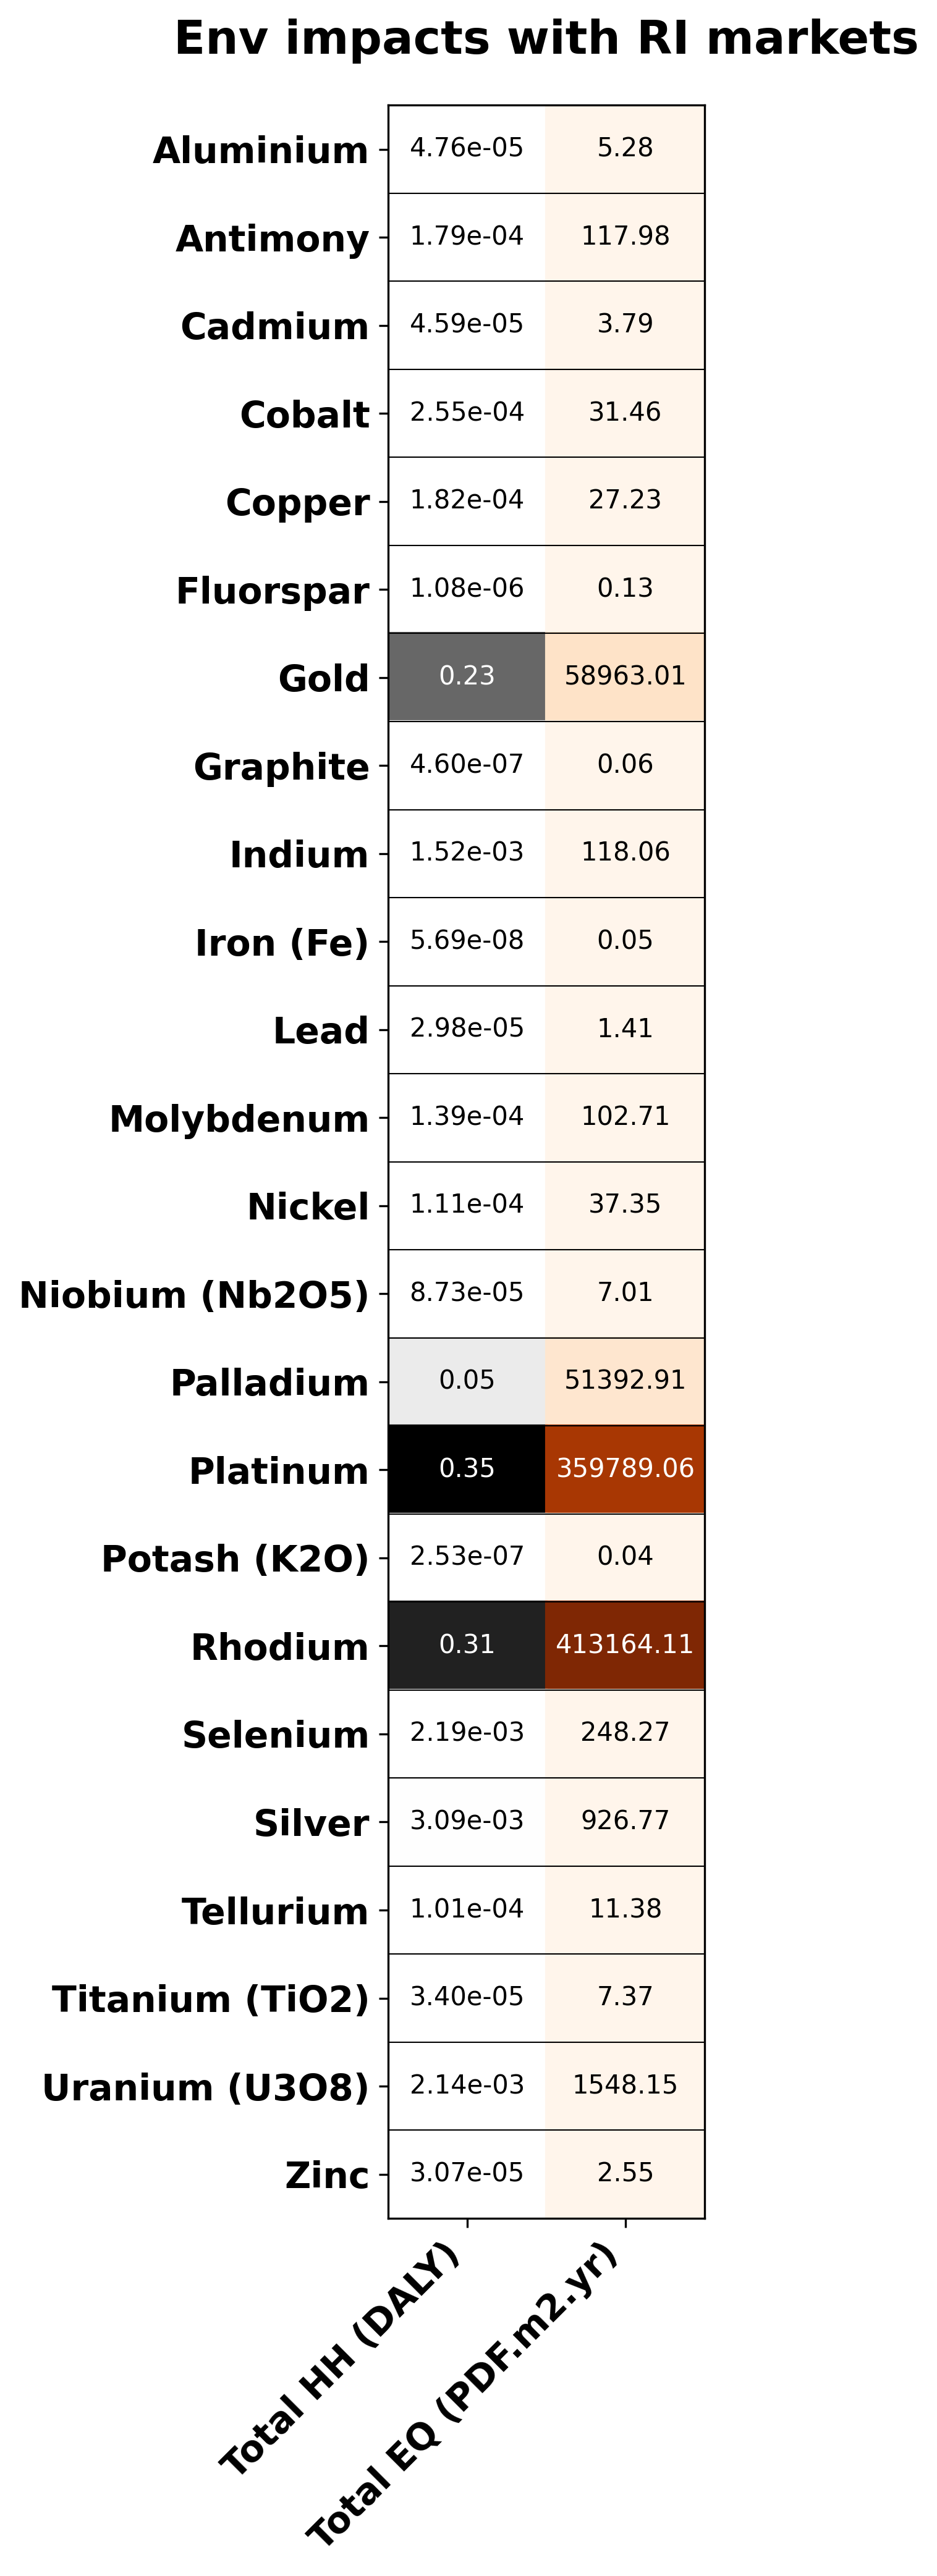

In [30]:
heatmap_lca(specific_lca_ri, 
            title='Env impacts with RI markets', 
            save_path='results/production_impacts_2023/env_impacts_markets_ri.png')

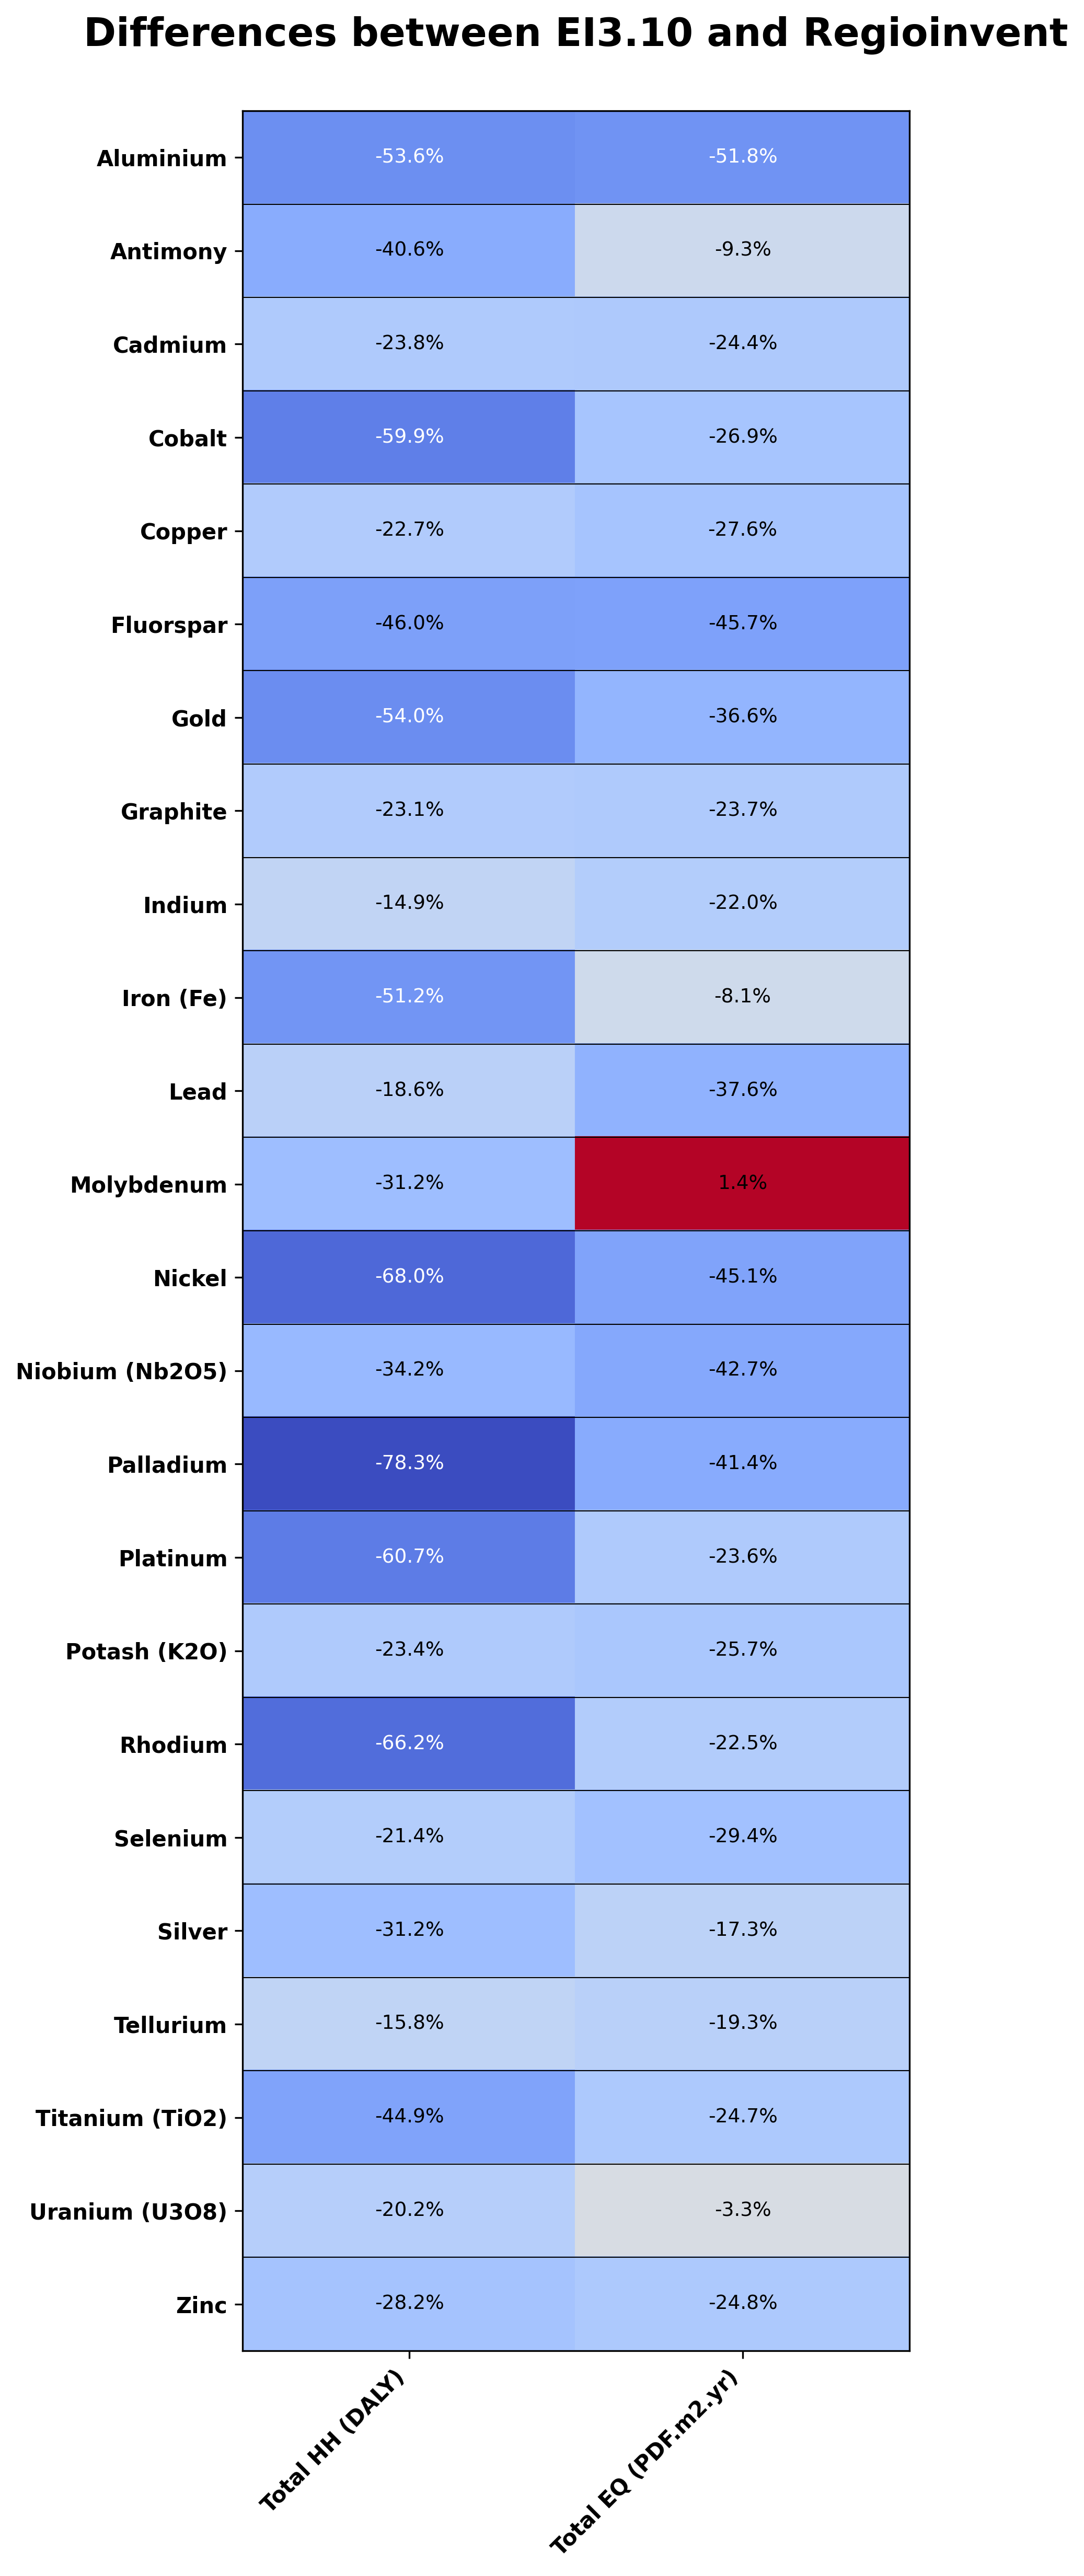

In [45]:
heatmap_db_comparison(specific_lca_ei, 
                      specific_lca_ri, 
                    title="Differences between EI3.10 and Regioinvent", 
                    save_path='results/production_impacts_2023/differences_ei_ri.png')


# Scale Regioinvent with 2023 production 

In [40]:
canada_production_df_kg = pd.read_csv(r'data/World_mining_data_2024/canada_production_wmd2024_kg.csv')

In [41]:
# We make sure we have the same number of commodities
canada_production_df_kg["Commodity"].nunique() == specific_lca_ri['Commodity'].nunique()

NameError: name 'specific_lca_ri' is not defined

In [37]:
df_2023 = pd.merge(canada_production_df_kg, specific_lca_ri, left_on='Commodity', right_on='Commodity')

In [38]:
df_2023

,Commodity,Production Volume (kg),World Share (%),Total HH (DALY),Total EQ (PDF.m2.yr)
0,Aluminium,3.033966e+09,4.408193,4.757306e-05,5.280072
1,Antimony,2.000000e+03,0.002409,1.789925e-04,117.978604
2,Cadmium,1.800000e+06,7.825066,4.585213e-05,3.794301
3,Cobalt,3.063000e+06,1.844847,2.554897e-04,31.457421
4,Copper,5.107820e+08,2.298189,1.820514e-04,27.227589
5,Fluorspar,2.000000e+07,0.216534,1.081942e-06,0.129954
6,Gold,2.058310e+05,6.193863,2.314741e-01,58963.009689
7,Graphite,1.300000e+07,0.752539,4.595039e-07,0.061759
8,Indium,3.900000e+04,3.869048,1.522150e-03,118.056347
9,Iron (Fe),4.207390e+10,2.718035,5.689976e-08,0.048911


In [39]:
# Multiply the production volume by each impact category column
impact_columns = ['Total HH (DALY)', 'Total EQ (PDF.m2.yr)']  # Replace these with actual column names in your impact DataFrame
for col in impact_columns:
    df_2023[f'{col} Impact'] = df_2023['Production Volume (kg)'] * df_2023[col]
df_2023.columns

Index(['Commodity', 'Production Volume (kg)', 'World Share (%)',
       'Total HH (DALY)', 'Total EQ (PDF.m2.yr)', 'Total HH (DALY) Impact',
       'Total EQ (PDF.m2.yr) Impact'],
      dtype='object')

In [40]:
df_2023

,Commodity,Production Volume (kg),World Share (%),Total HH (DALY),Total EQ (PDF.m2.yr),Total HH (DALY) Impact,Total EQ (PDF.m2.yr) Impact
0,Aluminium,3.033966e+09,4.408193,4.757306e-05,5.280072,144335.051053,1.601956e+10
1,Antimony,2.000000e+03,0.002409,1.789925e-04,117.978604,0.357985,2.359572e+05
2,Cadmium,1.800000e+06,7.825066,4.585213e-05,3.794301,82.533837,6.829742e+06
3,Cobalt,3.063000e+06,1.844847,2.554897e-04,31.457421,782.564968,9.635408e+07
4,Copper,5.107820e+08,2.298189,1.820514e-04,27.227589,92988.568375,1.390736e+10
5,Fluorspar,2.000000e+07,0.216534,1.081942e-06,0.129954,21.638837,2.599072e+06
6,Gold,2.058310e+05,6.193863,2.314741e-01,58963.009689,47644.537988,1.213642e+10
7,Graphite,1.300000e+07,0.752539,4.595039e-07,0.061759,5.973550,8.028658e+05
8,Indium,3.900000e+04,3.869048,1.522150e-03,118.056347,59.363841,4.604198e+06
9,Iron (Fe),4.207390e+10,2.718035,5.689976e-08,0.048911,2393.994777,2.057896e+09


In [41]:
# Resulting DataFrame contains original production volume and multiplied impacts
df_2023_result = df_2023[[ 'Commodity', 'Production Volume (kg)', 'World Share (%)', 
                            'Total HH (DALY) Impact',
                            'Total EQ (PDF.m2.yr) Impact']]

In [42]:
df_2023_result

,Commodity,Production Volume (kg),World Share (%),Total HH (DALY) Impact,Total EQ (PDF.m2.yr) Impact
0,Aluminium,3.033966e+09,4.408193,144335.051053,1.601956e+10
1,Antimony,2.000000e+03,0.002409,0.357985,2.359572e+05
2,Cadmium,1.800000e+06,7.825066,82.533837,6.829742e+06
3,Cobalt,3.063000e+06,1.844847,782.564968,9.635408e+07
4,Copper,5.107820e+08,2.298189,92988.568375,1.390736e+10
5,Fluorspar,2.000000e+07,0.216534,21.638837,2.599072e+06
6,Gold,2.058310e+05,6.193863,47644.537988,1.213642e+10
7,Graphite,1.300000e+07,0.752539,5.973550,8.028658e+05
8,Indium,3.900000e+04,3.869048,59.363841,4.604198e+06
9,Iron (Fe),4.207390e+10,2.718035,2393.994777,2.057896e+09


In [43]:
df_2023_result.to_csv('results/production_impacts_2023/env_impacts_2023.csv', index=False)

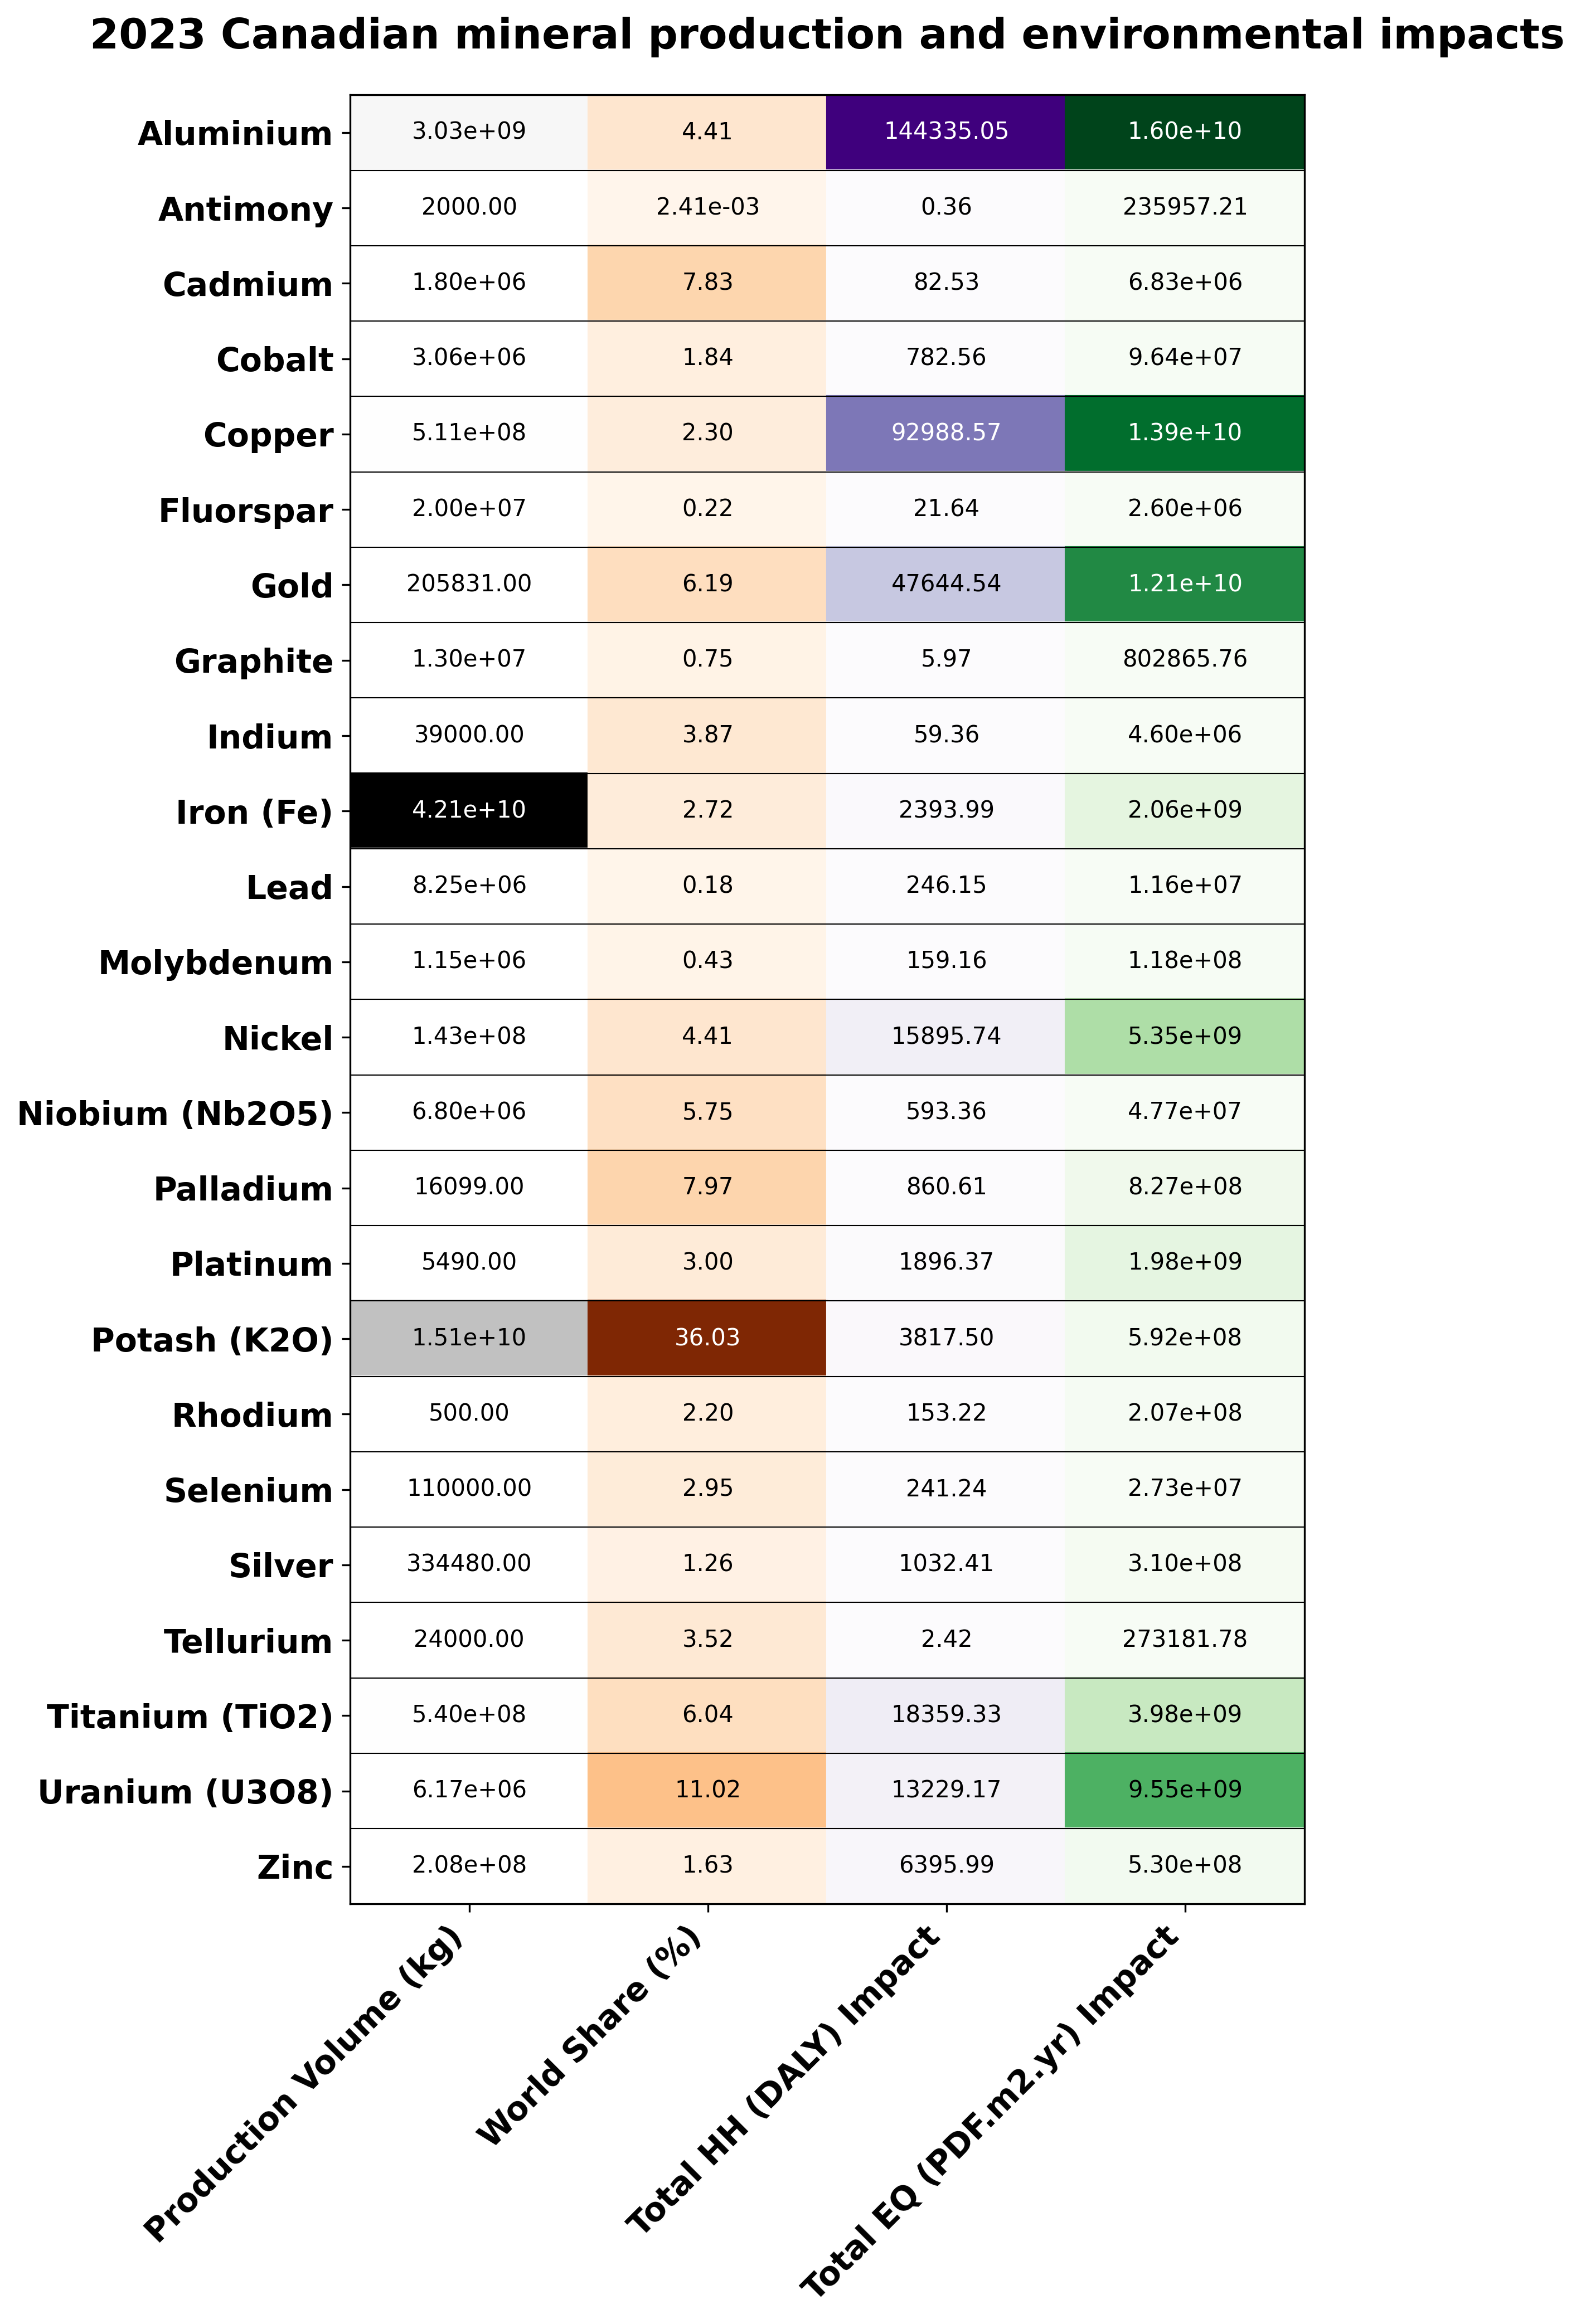

In [44]:
heatmap_lca(df_2023_result,
            title = '2023 Canadian mineral production and environmental impacts',
            save_path='results/production_impacts_2023/canada_2023_production_impacts_regioinvent.png')